(1260, 19)
Fitting 10 folds for each of 324 candidates, totalling 3240 fits
Best Parameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Test Accuracy: 0.9761904761904762
Training Accuracy: 0.9930555555555556


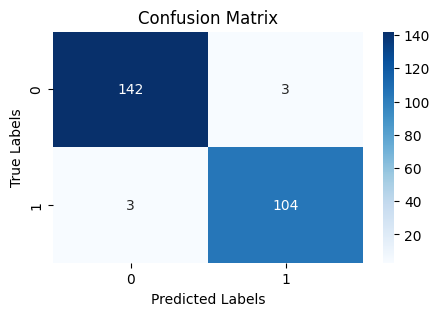


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       145
           1       0.97      0.97      0.97       107

    accuracy                           0.98       252
   macro avg       0.98      0.98      0.98       252
weighted avg       0.98      0.98      0.98       252



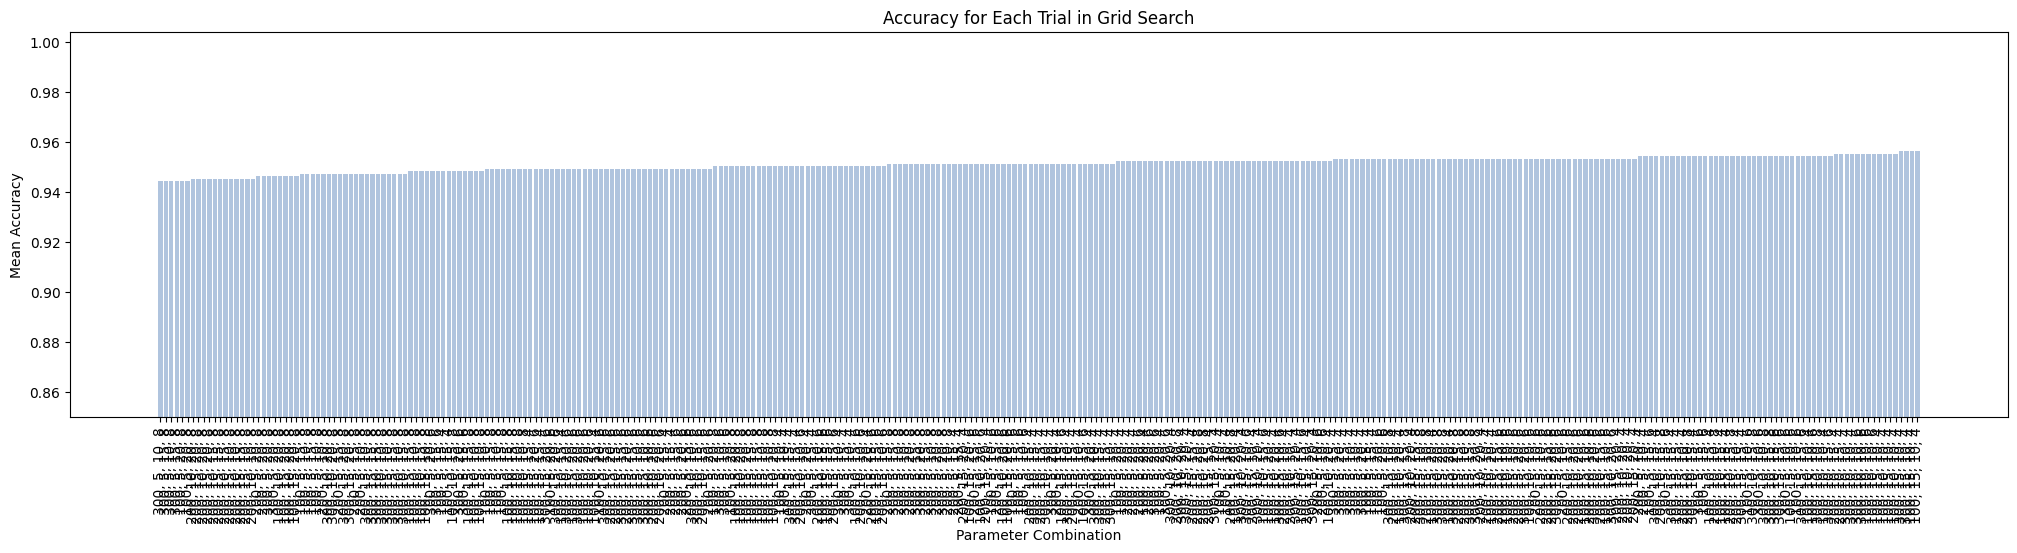

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score



# Load the dataset
file_path = 'transformed_data/decay_input_features_2014.csv'
df = pd.read_csv(file_path)

# Replace NaNs with 0
df.fillna(0, inplace=True)
print(df.shape)

# Define features (excluding Event ID and Target Label)
ignored_cols = ['Event ID', 'Target Label']
X = df.drop(columns=ignored_cols)
y = df['Target Label']  # Target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train
X_test_scaled = X_test

# # Feature selection based on importance
# rf_feature_selection = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_feature_selection.fit(X_train, y_train)
# feature_importance = pd.Series(rf_feature_selection.feature_importances_, index=X.columns).sort_values(ascending=False)
# top_features = feature_importance.head(10).index.tolist()  # Select top 10 features

# X_train_selected = X_train[top_features]
# X_test_selected = X_test[top_features]

def select_features(X_train, y_train, max_features=10):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    
    scores = []
    for n in range(1, max_features + 1):
        features = importances.nlargest(n).index
        X_selected = X_train[features]
        score = cross_val_score(RandomForestClassifier(random_state=42), X_selected, y_train, cv=5).mean()
        scores.append((n, score))
    
    optimal_n = max(scores, key=lambda x: x[1])[0]
    return importances.nlargest(optimal_n).index.tolist()

# Use function to select featurres
top_features = select_features(X_train, y_train)
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]


# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [4, 6, 8],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize and fit the model with GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=10, n_jobs=-1, verbose=1)
grid_search.fit(X_train_selected, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predictions and accuracy on test data
y_pred = best_model.predict(X_test_selected)  # Use X_test_selected instead of X_test_scaled
test_accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", test_accuracy)

# Predictions and accuracy on training data
y_train_pred = best_model.predict(X_train_selected)  # Use X_train_selected instead of X_train_scaled
training_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", training_accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plotting accuracy for each trial in the grid search
results = pd.DataFrame(grid_search.cv_results_)
results_sorted = results.sort_values(by='mean_test_score')

params_labels_sorted = []
for params in results_sorted['params']:
    label = f'{params["n_estimators"]}, {params["max_depth"]}, {params["min_samples_split"]}, {params["min_samples_leaf"]}'
    params_labels_sorted.append(label)

plt.figure(figsize=(25, 5))
plt.bar(np.arange(len(results_sorted)), results_sorted['mean_test_score'], color='lightsteelblue')
plt.xlabel('Parameter Combination')
plt.ylabel('Mean Accuracy')
plt.ylim(0.85)
plt.title('Accuracy for Each Trial in Grid Search')
plt.xticks(np.arange(len(results_sorted)), labels=params_labels_sorted, rotation=90)
plt.show()
